# GNN Code, mostly taken from Luke van Poppering

### Latex Macros
$\newcommand{\Re}[1]{{\mathbb{R}^{{#1}}}}
\newcommand{\Rez}{{\mathbb{R}}}$

# Notes
* Node2vec, struct2vect, etc. construct embeddings without a particular task. So node classification is not necessary in order to obtain embeddings. 
* The `ge` library has default embeddings of size 128, which is obviously overkill for the Karate Club Dataset. 

In [1]:
%load_ext autoreload
%autoreload 2
#%tableofcontents

In [2]:
import torch
import torch_scatter
import torch_sparse
import torch_geometric
import tqdm.auto
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import GNN_Tools as GNNT

In [3]:
### We use the famous 'Karate Club' network as a test case. Our task is to
### predict the community to which each node belongs; formally, this would be
### called transductive binary node classification.

import networkx as nx
G = nx.karate_club_graph()

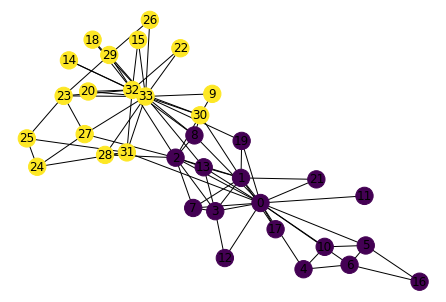

In [4]:
### Plot the network. We see it consists of a total of 34 nodes (numbered below 
### 0-33). Colors indicate class membership.
labels = [0 if G.nodes[idx]['club'] == 'Mr. Hi' else 1 for idx in range(len(G.nodes))]
pos = nx.drawing.layout.spring_layout(G)
nx.drawing.draw(G,pos=pos,with_labels=True,node_color=labels) 

In [5]:
### Write edge list to file.
### The attributes are synthetic
torch.manual_seed(0)
# All edges. Undirected edges appear twice: i->j and j->i
with open('edges.txt','w') as f:
  for edge in list(G.edges):
    f.write(f'{edge[0]} {edge[1]} {1.0}\n')
    # Karate Club file contains undirected edges
    f.write(f'{edge[1]} {edge[0]} {1.0}\n')

### Write node metadata to file. Nodes belonging to class '0' have features
### drawn from N(1,1). Nodes belonging to class '1' have features drawn from 
### the standard normal. So the features are the class label + 16 random numbers, 
### where the mean depends on the class. 
nb_Gnodes = len(list(G.nodes))
nb_rand_features = 10   # change value for experimentation
rands = np.random.randn(nb_Gnodes, 16)
with open('nodes.txt','w') as f:
  for node in list(G.nodes):
      if G.nodes[node]['club'] == 'Mr. Hi':
          X_str = " ".join([str(.5 + rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 0 ' + X_str + ' \n')
      elif G.nodes[node]['club'] == 'Officer':
          X_str = " ".join([str(rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 1 ' + X_str + ' \n')

### Read files into _Graph_ object.
karate_club_graph = GNNT.Graph()
karate_club_graph.read_edges('edges.txt')
karate_club_graph.read_node_metadata('nodes.txt')

In [6]:
### Write edge list to file.
### The attributes are synthetic
torch.manual_seed(0)
with open('edges.txt','w') as f:
  for edge in list(G.edges):
    f.write(f'{edge[0]} {edge[1]} {1.0}\n')

### Write node metadata to file. Nodes belonging to class '0' have features
### drawn from N(1,1). Nodes belonging to class '1' have features drawn from 
### the standard normal. So the features are the class label + 16 random numbers, 
### where the mean depends on the class. 
nb_Gnodes = len(list(G.nodes))
nb_rand_features = 16   # change value for experimentation
rands = np.random.randn(nb_Gnodes, 16)
with open('nodes.txt','w') as f:
  for node in list(G.nodes):
      if G.nodes[node]['club'] == 'Mr. Hi':
          X_str = " ".join([str(.5 + rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 0 ' + X_str + ' \n')
      elif G.nodes[node]['club'] == 'Officer':
          X_str = " ".join([str(rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 1 ' + X_str + ' \n')

### Read files into _Graph_ object.
karate_club_graph = GNNT.Graph()
karate_club_graph.read_edges('edges.txt')
karate_club_graph.read_node_metadata('nodes.txt')

In [7]:
len(G.nodes)
import numpy.linalg as alg
karate_club_graph.node_metadata;

In [8]:
graph = karate_club_graph

Linear model is 
$$ H^{n+1} = A H^n W $$
where $H\in \Re{N\times d}$, $A\in\Re{N\times N}$, and $W\in\Re{d\times d}$ and $d$ is the number of features. In our synthetic example, we have 16 features, one label. `

In [239]:
softmax = torch.nn.functional.softmax
relu = torch.nn.functional.relu
sigmoid = torch.nn.functional.sigmoid
tanh = torch.nn.functional.tanh
activation = sigmoid

def model(A, H0, W):
    """
    W : list of weights of different shapes
    """
    # print("A,H0,W shapes: ", A.shape, H0.shape, W[0].shape)
    X = relu(A @ H0 @ W[0])
    #X = relu(A @ X @ W[0])
    # print("A,X,W shapes: ", A.shape, X.shape, W[1].shape)
    X = sigmoid(A @ X @ W[1])
    # X = softmax(X, dim=1)   #  2 output dimensions
    #X = activation(X)   # 1 output dimension
    return X

In [263]:
### Create a hand-crafted GNN without using a formal model.

def model_setup(G, graph, frac_train=0.5, H0=None, nb_features=None, feature_type=None):
    """
    G is a networkx graph
    graph is an instance of the Graph class (Luke VP)
    """
    # # Ensure result reproducibility
    # torch.manual_seed(100)
    nb_nodes = len(G.nodes)
    nb_edges = len(G.edges)
    A = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
    # Check that graph is undirected if ||A-A.T|| = 0
    
    # print("Model setup, check A")
    # for i in range(3):
    #   for j in range(34):
    #     if A[i,j]:
    #         print("edge: ", i, j)
    
    # ATTENTION: THE NODE INDICES ARE NOT PERMUTED. IMPORTANT or NOT? 

    # Kipf and Welling (2016)
    An = np.eye(nb_nodes) + A
    D = np.sum(An, axis=0)  # degree
    Dinvsq = np.diag(np.sqrt(1. / D))  # array
    An = Dinvsq @ An @ Dinvsq
    
    # max|eig[i]| = 1
    # eig = alg.eig(An)[0]
    # print("eig: ", np.sort(eig))
    
    if H0 == None: 
        H0 = graph.node_metadata
    
    # Use -1 in case the matrix eventually changes number of dimensions
    if nb_features == None:
        nb_features = H0.shape[-1]
    else:
        # first column is a label
        H0 = graph.node_metadata[:, 0:nb_features+1]
        
    if feature_type == 'degree':
        nb_features = 1
        H0[:,1] = torch.tensor(np.sum(A, axis=0))
        H0[:,1] /= torch.max(H0[:,1])
    
    print("nb_features: ", nb_features)
        
    H = H0[:,1:1+nb_features]  # H only has features
    Y = H0[:,0]  # labels
    print("==> H,Y shape: ", H.shape, Y.shape)
    
    # 0: training set (50%); 1: testing set (50%)
    # mask = torch.from_numpy(np.random.randint(0, 2, H0.shape[0]))
    mask = torch.from_numpy(np.random.choice(2, H0.shape[0], p=[frac_train, 1.-frac_train]))
 
    H0 = H  # features
    # Use -1 in case the matrix eventually changes number of dimensions
    if nb_features == None:
        nb_features = H0.shape[-1]
    print("nb_features: ", nb_features)
    
    # Initialize W with random numbers and allow gradient 
    # computation of cost function with respect to (wrt) W

    W = []
    # I did initialize the weights, but only with non-scaled random numbers
    W.append( torch.rand(nb_features, nb_features, requires_grad=True) )
    # Binary classification (2 output features)
    #W1 = torch.rand(nb_features, 2, requires_grad=True)  # softmax output layer
    W.append( torch.rand(nb_features, 1, requires_grad=True) )  # sigmoid output layer
    
    # Glorot Initialization
    rmax = 1/nb_features**0.5
    for w in  W:
        torch.nn.init.uniform_(w, -rmax, rmax)
        
    An = torch.tensor(An, dtype=torch.float32)
    #A /= A.sum(dim=1)[:,None]  # Luke's suggestion, 2022-02-04. WHY this rescaling? 
    # A = torch.tensor(A, dtype=torch.float32)
    return An, H, H0, Y, W, mask

In [264]:
def cost(H, Y, mask, activation):
    """
    summation over all edges
    Training set: defined by mask[i] = 0
    H[i,0] is the probability of Y[i] == 1 (target probability)
    H[i,1] is the probability of Y[i] == 0 (target probability)
    """
    costf = 0
    
    if activation == "relu":
        for i in range(Y.shape[0]):
            if mask[i] == 0:  # training set
                costf -= (Y[i] * torch.log(H[i,0]) + (1-Y[i]) * torch.log(H[i,1]))
        
    elif activation == "sigmoid": 
        for i in range(Y.shape[0]):
            if mask[i] == 0:  # training set
                # costf -= torch.log(H[i,0])
                costf -= (Y[i] * torch.log(H[i,0]) + (1-Y[i]) * torch.log(1.-H[i,0]))


                
    else:
        print(f"activation {activation} is not supported.")
    
    return costf

In [265]:
def train(A, H, H0, Y, W, graph, mask, nb_epochs, activation, lr=1.e-2):
    
    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/

    print("cost(H0, Y, mask): ", H0.shape, Y.shape, mask.shape)
    loss = [cost(H0, Y, mask, activation)]
    for epoch in range(nb_epochs):
        H = model(A, H0, W)
        costf = cost(H, Y, mask, activation)
        loss.append(costf)
        if np.isnan(costf.detach().item()):
            print("costf is NaN")
            break
        with torch.no_grad():
            # Why does it not work with the argument True?
            costf.backward(retain_graph=False)  # otherwise graph is discarded. How to regenerate it?

            for w in W:
                w -= lr * w.grad
                w.grad.zero_()
        if epoch % 100 == 0:
            print("============================")
            predict(A, H0, Y, W, mask, activation="sigmoid")
            pass
    return loss

In [266]:
def predict(A, H0, Y, W, mask, activation):
    
    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/
    H = model(A, H0, W)
    
    if activation == "relu":
        count = [0,0]
        count_correct = [0,0]
        for i in range(H.shape[0]):
            if mask[i] == 1:
                count[0] += 1
                if H[i,0] > 0.5 and Y[i] > 0.9:
                    count_correct[0] += 1
                elif H[i,1] < 0.5 and Y[i] < 0.1:
                    count_correct[1] += 1
        perc0_corr = count_correct[0] / count[0]
        perc1_corr = count_correct[1] / count[0]
        print("sum(H): ", torch.sum(H, axis=0))
        print("Perc (%) class 0/1 correct: ", perc0_corr, perc1_corr)
    elif activation == "sigmoid":    # <<<< CASE BEING USED (2022-02-03)
        count_correct = [0,0]
        count = [0,0]
        for i in range(H.shape[0]):
            if mask[i] == 1: # test data
                count[1] += 1
                if H[i] > 0.5 and Y[i] > 0.9:
                    count_correct[1] += 1
                if H[i] < 0.5 and Y[i] < 0.1:
                    count_correct[1] += 1
            else:  # mask == 0, training data
                count[0] += 1
                if H[i] > 0.5 and Y[i] > 0.9:
                    count_correct[0] += 1
                if H[i] < 0.5 and Y[i] < 0.1:
                    count_correct[0] += 1
        perc0_corr = count_correct[0] / count[0]
        perc1_corr = count_correct[1] / count[1]
        print("Perc (%) class (training) correct: ", perc0_corr)
        print("Perc (%) class (testing) correct: ", perc1_corr)
    else:
        print("predict(): Incorrect activation function")
        return

## Observations
By default, the features are two normal distributions (16 values per node, so there are 16 features). 
One Gaussian is placed over its appropriate label (there are two labels). With 16 features, I experiment with the fraction of nodes in the training set. I choose a fraction `frac_train` of the nodes as the training set. 

When `frac_train` goes to 0.05, there are very few nodes in the training set. However, as long is there is at least one node of each type, I get good test accuracy. 

For a given value of `frac_train`, testing accuracy goes down as I decrease the number of features. In the limit of a single feature, there is not enough information to distinguish the two distributions, and accuracy decreases.

To further test the code with 16 features, I permute the attributes amongst the nodes. Now, the two Gaussians no longer match the two labels in the graph. The label prediction  accuracy goes down substantially, ending up closer to 50% accuracy, which is random. 

One can also use structural information for features, such as node degree. I would not expect great accuracy in that case. 

In the cell that follows, feature_type is `None` specifies the two Gaussians centered at 0 and 1. If `feature_type` is `degree`, use the node degree as the single feature. The accuracy of the testing is quite low in that case. Sometimes I get zero accuracy on training and testing data, and sometimes I get about 50% on both. I do NOT know why I get zero accuracy when `frac_train=0.5`. Seems unlikely. When `frac_train=0.8`, I sometimes get zero, and sometimes 0.55 on training set and 0.2 on testing set. Obviously, the degree is a poor choice for a feature as it seems decorrelated from the labels. Note also, that I divided the degree by the maximum degree over the graph to keep it in the range `[0,1]`.

In [277]:
A, H, H0, Y, W, mask = model_setup(G, graph, frac_train=0.8, nb_features=6, feature_type='degree')
print("H: ", H.shape)
print("nb_features: ", H.shape[1])
index = torch.where(mask == 0, True, False)
print("labels where mask == 0: ", Y[index])
loss = train(A, H, H0, Y, W, graph, mask, nb_epochs=2501, activation="sigmoid")

# When running frac_train=0.05 (0.05 * 34 = 1.7), I sometimes get 0, 1, or 2 0 masks. 
# When there are 0 training labels, I get an error
# When there is 1 training label, I get 50% error, i.e., 50% accuracy (random)
# When there are 2 training labels, I get close to 100% accuracy

nb_features:  1
==> H,Y shape:  torch.Size([34, 1]) torch.Size([34])
nb_features:  1
H:  torch.Size([34, 1])
nb_features:  1
labels where mask == 0:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
cost(H0, Y, mask):  torch.Size([34, 1]) torch.Size([34]) torch.Size([34])
Perc (%) class (training) correct:  0.5517241379310345
Perc (%) class (testing) correct:  0.2
Perc (%) class (training) correct:  0.5517241379310345
Perc (%) class (testing) correct:  0.2
Perc (%) class (training) correct:  0.5517241379310345
Perc (%) class (testing) correct:  0.2
Perc (%) class (training) correct:  0.5517241379310345
Perc (%) class (testing) correct:  0.2
Perc (%) class (training) correct:  0.5517241379310345
Perc (%) class (testing) correct:  0.2
Perc (%) class (training) correct:  0.5517241379310345
Perc (%) class (testing) correct:  0.2
Perc (%) class (training) correct:  0.5517241379310345
Perc (%) class (testing)

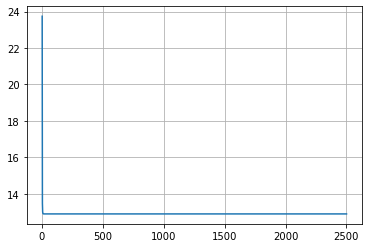

2502

In [258]:
plt.plot(loss) #[0:500])
plt.grid(True)
plt.show()
len(loss)

# Decoupling attributes/labels from structure
The question is: how important is the structural information? To determine that, we keep the graph fixed, but shuffle the labels across the graph nodes:
The number of each label will remain the same, but the labels, together with the attributes, will migrate to different nodes. 
Therefore, the edge connections  are no longer related to the edges. In that situation, one expects labelling accuracy to go down. 

This is accomplished by reshuffling the rows of `graph.node_metadata`. So first create a node permutation. 

In [132]:
A, H, H0, Y, W, mask = model_setup(G, graph, frac_train=0.05) 

nb_features:  16


In [207]:
print(H0.shape)
print(perm_nodes.shape)
print("perm_nodes: ", perm_nodes)
print("H0.shape: ", H0.shape)
print(type(H0))
H0 = H0[perm_nodes]
print("H0.shape: ", H0.shape)

torch.Size([34, 6])
(34,)
perm_nodes:  [ 8  1 21  6 20 16  0  2 13 25 15 11  9 33  4 12 29 28  3 23 26 32 14  7
  5 27 10 24 30 19 22 18 31 17]
H0.shape:  torch.Size([34, 6])
<class 'torch.Tensor'>
H0.shape:  torch.Size([34, 6])


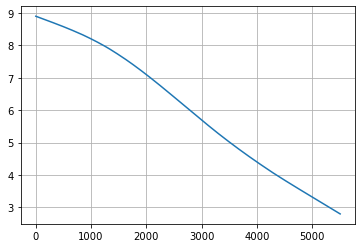

5502

In [138]:
plt.plot(loss) #[0:500])
plt.grid(True)
plt.show()
len(loss)

# I am not getting good accuracies for node classification. So I will do the following: 
* find a program on Github working with the Karate Club data
* Calculate accuracy with Luke's code, which uses sparse library
* Write my own code using Pytorch but without Sparse. 